In [1]:
from collections import defaultdict

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import tqdm
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# uint8 is not popular
y_train = y_train.astype('i4')
y_test = y_test.astype('i4')

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype('f4')
x_test = x_test[..., tf.newaxis].astype('f4')
n_train = x_train.shape[0]

In [3]:
latent_dim = 32
latent_prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim), scale_diag=tf.ones(latent_dim))

encoder = tfk.Sequential([
    tfk.layers.Reshape((28, 28, 1)),
    tfk.layers.Convolution2D(filters=16, kernel_size=3, activation='relu'),
    tfk.layers.MaxPool2D(),
    tfk.layers.Flatten(),
    tfk.layers.Dense(tfp.layers.IndependentNormal.params_size(latent_dim), activation='relu'),
    tfp.layers.IndependentNormal(latent_dim),
    tfp.layers.KLDivergenceAddLoss(latent_prior),
])

decoder = tfk.Sequential([
    tfk.layers.Dense(24*24*1, activation='relu'),
    tfk.layers.Reshape((24, 24, 1)),
    tfk.layers.Conv2DTranspose(filters=16, kernel_size=5, activation='relu'),
    tfk.layers.Conv2DTranspose(filters=1, kernel_size=1, activation='sigmoid'),
])

In [4]:
optimizer = tfk.optimizers.Adam()

train_loss = tfk.metrics.Mean(name='train_loss')
test_loss = tfk.metrics.Mean(name='test_loss')

BATCH_SIZE = 64

train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .shuffle(10000)
            .batch(BATCH_SIZE, drop_remainder=True)
           )

test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
           .batch(BATCH_SIZE, drop_remainder=True)
          )

In [5]:
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        latent = encoder(images)
        activations = decoder(latent)
        nll = tfk.metrics.binary_crossentropy(tf.reshape(images, (images.shape[0], -1)),
                                              tf.reshape(activations, (activations.shape[0], -1))
                                             )
        kl = tf.reduce_sum(encoder.losses) / n_train
        loss = tf.reduce_mean(nll) + kl

    trainable = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable)
    optimizer.apply_gradients(zip(gradients, trainable))

    train_loss(loss)

In [6]:
@tf.function
def test_step(images):
    activations = decoder(encoder(images))
    loss = tfk.metrics.binary_crossentropy(images, activations)

    test_loss(loss)

In [7]:
EPOCHS = 10
history = defaultdict(list)

for epoch in tqdm.trange(EPOCHS, unit='epoch'):
    if epoch == 10:
        optimizer.lr = 1e-4
    for images, labels in train_ds:
        train_step(images)

    for test_images, test_labels in test_ds:
        test_step(test_images)

    history['train_loss'].append(float(train_loss.result()))
    history['test_loss'].append(float(test_loss.result()))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    test_loss.reset_states()
    

  0%|          | 0/10 [00:00<?, ?epoch/s]WARNING: Logging before flag parsing goes to stderr.
W1004 12:07:46.616050 140736140739456 deprecation.py:323] From /Users/ncsmith/miniconda3/envs/tfd/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 10/10 [04:07<00:00, 24.76s/epoch]


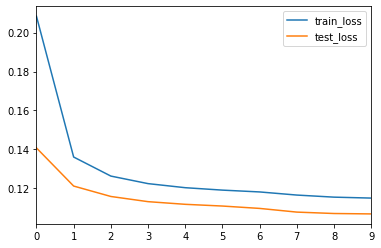

In [8]:
pd.DataFrame(history).plot()

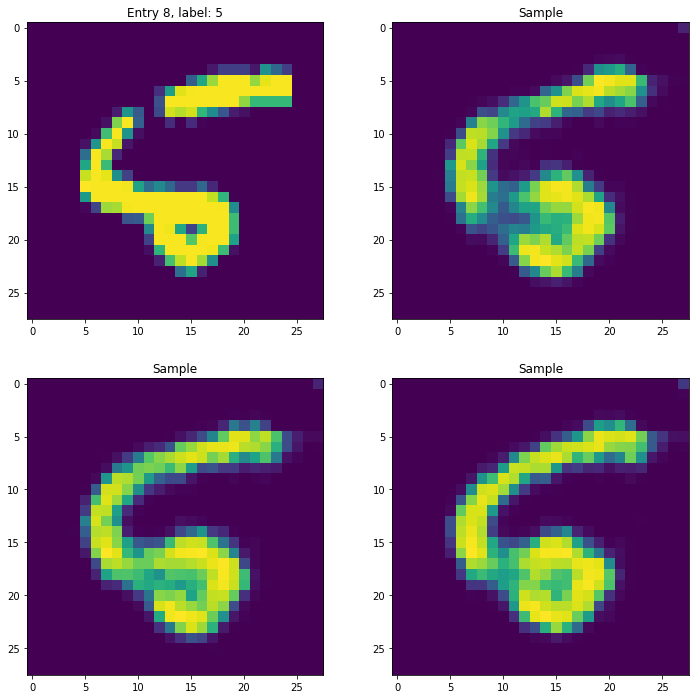

In [11]:
i = 8

ex = x_test[i,...,0]
lbl = y_test[i]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

axes[0][0].set_title("Entry %d, label: %d" % (i, lbl))
axes[0][0].imshow(ex)

latent = encoder(ex[None, ..., None])

for ax in axes.flatten()[1:]:
    ax.set_title('Sample')
    ax.imshow(decoder(latent.sample())[0, ..., 0])

In [10]:
latent.distribution.parameters

{'loc': <tf.Tensor: id=23919, shape=(1, 32), dtype=float32, numpy=
 array([[ 5.152866  ,  4.2402287 ,  6.2619734 ,  7.364183  ,  0.30590352,
          0.        ,  9.116695  ,  0.        ,  0.        ,  0.        ,
          5.1815224 ,  4.1679997 ,  2.239747  ,  0.        ,  0.        ,
          0.        , 16.605696  ,  0.        ,  0.        ,  4.776956  ,
          3.7043784 ,  4.2118387 ,  3.3704407 ,  2.5699058 ,  4.6944942 ,
          0.        ,  0.        ,  4.2199807 ,  0.        ,  7.6706386 ,
          1.5021064 ,  0.92557776]], dtype=float32)>,
 'scale': <tf.Tensor: id=23921, shape=(1, 32), dtype=float32, numpy=
 array([[0.6931472, 0.6931472, 0.6931472, 0.6931472, 0.6931472, 0.6931472,
         0.6931472, 0.6931472, 0.6931472, 0.6931472, 0.6931472, 0.6931472,
         0.6931472, 0.6931472, 0.6931472, 0.6931472, 0.6931472, 0.6931472,
         0.6931472, 0.6931472, 0.6931472, 0.6931472, 0.6931472, 0.6931472,
         0.6931472, 0.6931472, 0.6931472, 0.6931472, 0.6931472, 0.